In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import glob
import cv2

IMAGE_SIZE = 256

# Function to load images
def load_images(image_paths, sample_n_images=50):
    formatted_images = []
    num_images = len(image_paths)
    if num_images <= 0:
        print("No images found in the specified directory.")
        return formatted_images
    indices = np.random.randint(0, num_images, sample_n_images)
    for i in indices:
        input_image = cv2.imread(image_paths[i])
        if input_image is None:
            print(f"Failed to read image: {image_paths[i]}")
            continue
        # Resize image
        resized_image = cv2.resize(input_image, (IMAGE_SIZE, IMAGE_SIZE))
        # Normalize pixel values
        resized_image = resized_image / 255.0
        formatted_images.append(resized_image)
    return np.array(formatted_images)

# Generator model
def build_generator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Residual blocks
    for _ in range(9):
        x = res_block(x)
    
    # Decoder
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    outputs = Conv2D(3, kernel_size=7, activation='sigmoid', padding='same')(x)
    
    return Model(inputs, outputs)

# Residual block
def res_block(x):
    filters = x.shape[-1]
    shortcut = x
    
    # First convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Add shortcut connection
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x

# Discriminator model
def build_discriminator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(512, kernel_size=4, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    outputs = Conv2D(1, kernel_size=4, strides=1, padding='same')(x)
    
    return Model(inputs, outputs)

# Define loss functions
mse_loss = MeanSquaredError()

# Build and compile the generators
generator_AB = build_generator()
generator_BA = build_generator()

# Build and compile the discriminators
discriminator_A = build_discriminator()
discriminator_B = build_discriminator()

# Compile the discriminators
discriminator_A.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss=mse_loss)
discriminator_B.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss=mse_loss)

# Build and compile the combined model
input_A = Input(shape=(256, 256, 3))
input_B = Input(shape=(256, 256, 3))

fake_B = generator_AB(input_A)
fake_A = generator_BA(input_B)

reconstructed_A = generator_BA(fake_B)
reconstructed_B = generator_AB(fake_A)

discriminator_A.trainable = False
discriminator_B.trainable = False

valid_A = discriminator_A(fake_A)
valid_B = discriminator_B(fake_B)

combined_model = Model(inputs=[input_A, input_B], outputs=[valid_A, valid_B, reconstructed_A, reconstructed_B])
combined_model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss=[mse_loss, mse_loss, 'mae', 'mae'])

# Load daytime and nighttime images
day_images = glob.glob('/kaggle/input/data155/DAY/*.jpg')
night_images = glob.glob('/kaggle/input/data155/NIGHT/*.jpg')

trainA = load_images(day_images, sample_n_images=len(day_images))
trainB = load_images(night_images, sample_n_images=len(night_images))

# Train the model
combined_model.fit([trainA, trainB], [np.ones((len(trainA), 32, 32, 1)), np.ones((len(trainB), 32, 32, 1)), trainA, trainB], epochs=100, batch_size=1)

# Save the models
generator_AB.save('generator_AB.h5')
generator_BA.save('generator_BA.h5')


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm

# Function to calculate Fréchet Inception Distance (FID)
def calculate_fid(images1, images2):
    # Load pre-trained InceptionV3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(256, 256, 3))
    
    # Preprocess images
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)
    
    # Get Inception activations for real and generated images
    activations1 = model.predict(images1)
    activations2 = model.predict(images2)
    
    # Calculate mean and covariance statistics
    mu1, sigma1 = np.mean(activations1, axis=0), np.cov(activations1, rowvar=False)
    mu2, sigma2 = np.mean(activations2, axis=0), np.cov(activations2, rowvar=False)
    
    # Calculate FID score
    fid_score = np.sum((mu1 - mu2)**2) + np.trace(sigma1 + sigma2 - 2 * sqrtm(sigma1.dot(sigma2)))
    
    return fid_score

# Function to calculate Inception Score (IS)
def calculate_is(images, n_split=10, eps=1e-16):
    # Load pre-trained InceptionV3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(256, 256, 3))
    
    # Preprocess images
    images = preprocess_input(images)
    
    # Get Inception activations for images
    activations = model.predict(images)
    
    # Split activations into n_split batches
    scores = []
    for i in range(n_split):
        split_size = activations.shape[0] // n_split
        split_activations = activations[i * split_size:(i + 1) * split_size]
        # Calculate softmax probabilities for each activation
        p_yx = model.predict(split_activations)
        # Calculate marginal probability over classes
        p_y = np.expand_dims(np.mean(p_yx, axis=0), 0)
        # Calculate KL divergence
        kl_divergence = np.sum(p_yx * (np.log(p_yx + eps) - np.log(p_y + eps)), axis=1)
        # Calculate Inception Score for each split
        is_score = np.exp(np.mean(kl_divergence))
        scores.append(is_score)
    
    # Return mean and standard deviation of Inception Scores
    return np.mean(scores), np.std(scores)

# Function to calculate Cycle-Consistency Loss
def calculate_cycle_consistency_loss(real_images, reconstructed_images):
    return np.mean(np.abs(real_images - reconstructed_images))

# Load the trained generators
generator_AB = tf.keras.models.load_model('generator_AB.h5')
generator_BA = tf.keras.models.load_model('generator_BA.h5')

# Generate fake images using the generators
fake_images_AB = generator_AB.predict(trainA)
fake_images_BA = generator_BA.predict(trainB)

# Calculate Fréchet Inception Distance (FID) between real and fake images
fid_score_AB = calculate_fid(trainB, fake_images_AB)
fid_score_BA = calculate_fid(trainA, fake_images_BA)
print("FID Score (A to B):", fid_score_AB)
print("FID Score (B to A):", fid_score_BA)

# Calculate Inception Score (IS) for fake images
is_mean_AB, is_std_AB = calculate_is(fake_images_AB)
is_mean_BA, is_std_BA = calculate_is(fake_images_BA)
print("Inception Score (Mean, A to B):", is_mean_AB)
print("Inception Score (Std, A to B):", is_std_AB)
print("Inception Score (Mean, B to A):", is_mean_BA)
print("Inception Score (Std, B to A):", is_std_BA)

# Calculate Cycle-Consistency Loss
cycle_loss_AB = calculate_cycle_consistency_loss(trainA, generator_BA.predict(fake_images_AB))
cycle_loss_BA = calculate_cycle_consistency_loss(trainB, generator_AB.predict(fake_images_BA))
print("Cycle-Consistency Loss (A to B):", cycle_loss_AB)
print("Cycle-Consistency Loss (B to A):", cycle_loss_BA)



In [20]:
# Generate fake images using the generators
fake_images_AB = generator_AB.predict(trainA)
fake_images_BA = generator_BA.predict(trainB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 468ms/step


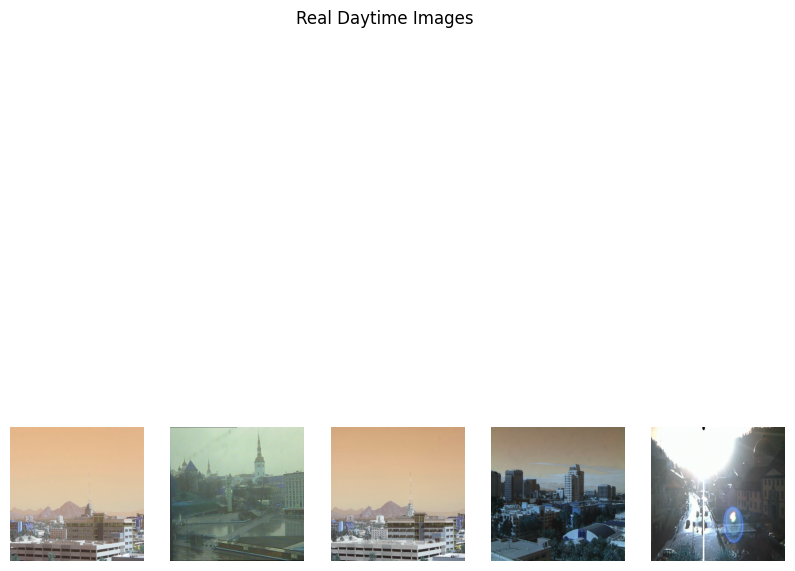

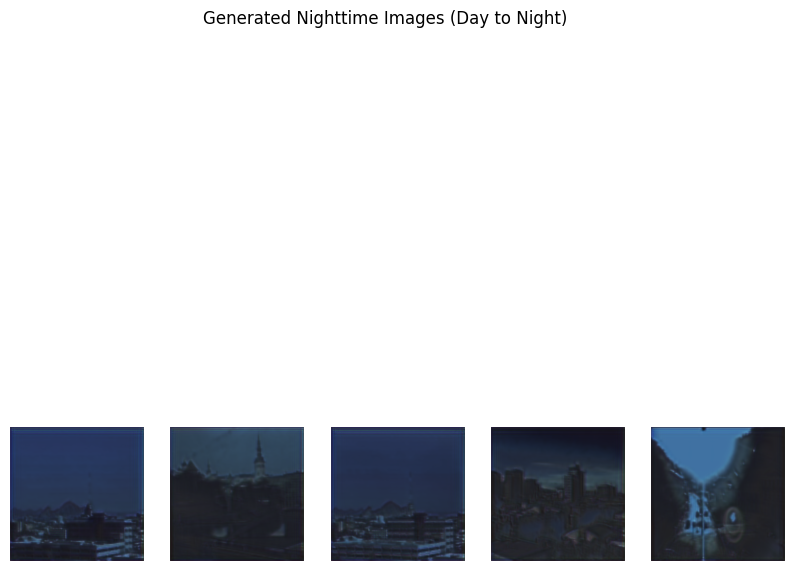

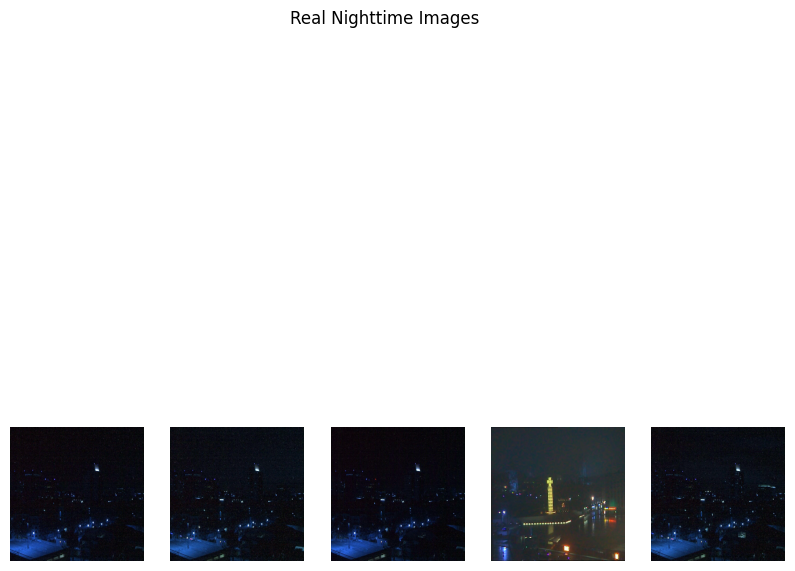

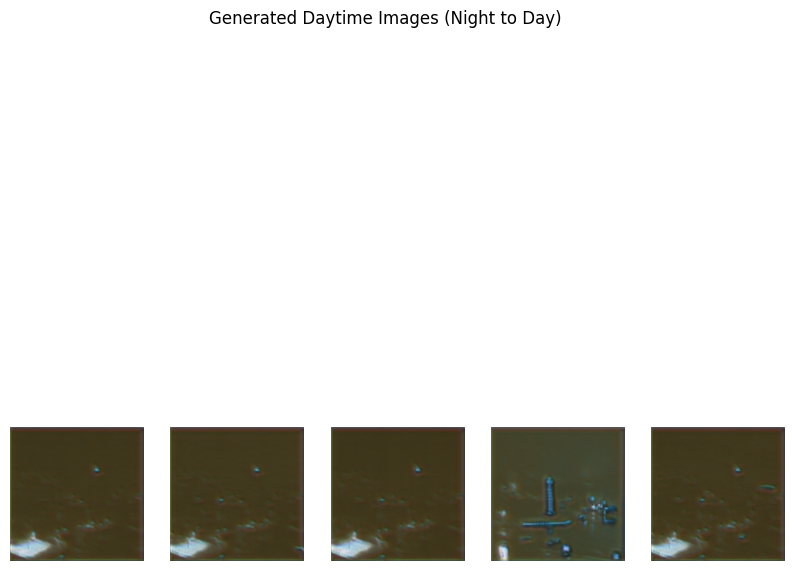

In [24]:
import matplotlib.pyplot as plt

# Function to display images
def display_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display real and generated images
display_images(trainA[20:25], title='Real Daytime Images')
display_images(fake_images_AB[20:25], title='Generated Nighttime Images (Day to Night)')

display_images(trainB[20:25], title='Real Nighttime Images')
display_images(fake_images_BA[20:25], title='Generated Daytime Images (Night to Day)')


In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import glob
import cv2

# Detect and initialize the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# Instantiate a distribution strategy
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Function to load images
def load_images(image_paths, sample_n_images=50):
    formatted_images = []
    num_images = len(image_paths)
    if num_images <= 0:
        print("No images found in the specified directory.")
        return formatted_images
    indices = np.random.randint(0, num_images, sample_n_images)
    for i in indices:
        input_image = cv2.imread(image_paths[i])
        if input_image is None:
            print(f"Failed to read image: {image_paths[i]}")
            continue
        # Resize image
        resized_image = cv2.resize(input_image, (256, 256))
        # Normalize pixel values
        resized_image = resized_image / 255.0
        formatted_images.append(resized_image)
    return np.array(formatted_images)

# Generator model
def build_generator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Residual blocks
    for _ in range(9):
        x = res_block(x)
    
    # Decoder
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    outputs = Conv2D(3, kernel_size=7, activation='sigmoid', padding='same')(x)
    
    return Model(inputs, outputs)

# Residual block
def res_block(x):
    filters = x.shape[-1]
    shortcut = x
    
    # First convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Add shortcut connection
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x

# Discriminator model
def build_discriminator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(512, kernel_size=4, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    outputs = Conv2D(1, kernel_size=4, strides=1, padding='same')(x)
    
    return Model(inputs, outputs)

# Define loss functions
mse_loss = MeanSquaredError()

# Build and compile the generators
with tpu_strategy.scope():
    generator_AB = build_generator()
    generator_BA = build_generator()

# Build and compile the discriminators
with tpu_strategy.scope():
    discriminator_A = build_discriminator()
    discriminator_B = build_discriminator()

# Compile the discriminators
with tpu_strategy.scope():
    discriminator_A.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss=mse_loss)
    discriminator_B.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss=mse_loss)

# Build and compile the combined model
with tpu_strategy.scope():
    input_A = Input(shape=(256, 256, 3))
    input_B = Input(shape=(256, 256, 3))

    fake_B = generator_AB(input_A)
    fake_A = generator_BA(input_B)

    reconstructed_A = generator_BA(fake_B)
    reconstructed_B = generator_AB(fake_A)

    discriminator_A.trainable = False
    discriminator_B.trainable = False

    valid_A = discriminator_A(fake_A)
    valid_B = discriminator_B(fake_B)

    combined_model = Model(inputs=[input_A, input_B], outputs=[valid_A, valid_B, reconstructed_A, reconstructed_B])
    combined_model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss=[mse_loss, mse_loss, 'mae', 'mae'])

# Load daytime and nighttime images
day_images = glob.glob('/kaggle/input/dayandnight/*.jpg')
night_images = glob.glob('/kaggle/input/nightd/*.jpg')

trainA = load_images(day_images, sample_n_images=len(day_images))
trainB = load_images(night_images, sample_n_images=len(night_images))

# Train the model
combined_model.fit([trainA, trainB], [np.ones((len(trainA), 32, 32, 1)), np.ones((len(trainB), 32, 32, 1)), trainA, trainB], epochs=100, batch_size=25)

# Save the models
with tpu_strategy.scope():
    generator_AB.save('generator_AB.h5')
    generator_BA.save('generator_BA.h5')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
import glob
import cv2

IMAGE_SIZE = 256

# Function to load images
def load_images(image_paths, sample_n_images=50):
    formatted_images = []
    num_images = len(image_paths)
    if num_images <= 0:
        print("No images found in the specified directory.")
        return formatted_images
    indices = np.random.randint(0, num_images, sample_n_images)
    for i in indices:
        input_image = cv2.imread(image_paths[i])
        if input_image is None:
            print(f"Failed to read image: {image_paths[i]}")
            continue
        # Resize image
        resized_image = cv2.resize(input_image, (IMAGE_SIZE, IMAGE_SIZE))
        # Normalize pixel values
        resized_image = resized_image / 255.0
        formatted_images.append(resized_image)
    return np.array(formatted_images)

# Generator model
def build_generator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Residual blocks
    for _ in range(9):
        x = res_block(x)
    
    # Decoder
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    outputs = Conv2D(3, kernel_size=7, activation='sigmoid', padding='same')(x)
    
    return Model(inputs, outputs)

# Residual block
def res_block(x):
    filters = x.shape[-1]
    shortcut = x
    
    # First convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Add shortcut connection
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x

# Discriminator model
def build_discriminator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(512, kernel_size=4, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    outputs = Conv2D(1, kernel_size=4, strides=1, padding='same')(x)
    
    return Model(inputs, outputs)

# Define loss functions
mse_loss = MeanSquaredError()
mae_loss = MeanAbsoluteError()

# Build and compile the generators
generator_AB = build_generator()
generator_BA = build_generator()

# Build and compile the discriminators
discriminator_A = build_discriminator()
discriminator_B = build_discriminator()

# Compile the discriminators
discriminator_A.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss=mse_loss)
discriminator_B.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss=mse_loss)

# Build and compile the combined model
input_A = Input(shape=(256, 256, 3))
input_B = Input(shape=(256, 256, 3))

fake_B = generator_AB(input_A)
fake_A = generator_BA(input_B)

reconstructed_A = generator_BA(fake_B)
reconstructed_B = generator_AB(fake_A)

discriminator_A.trainable = False
discriminator_B.trainable = False

valid_A = discriminator_A(fake_A)
valid_B = discriminator_B(fake_B)

combined_model = Model(inputs=[input_A, input_B], outputs=[valid_A, valid_B, reconstructed_A, reconstructed_B])
combined_model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                      loss=[mse_loss, mse_loss, mae_loss, mae_loss],
                      loss_weights=[1, 1, 10, 10])  # Adjust loss weights based on relative importance

# Load daytime and nighttime images
day_images = glob.glob('/kaggle/input/daynight/DAY/*.jpg')
night_images = glob.glob('/kaggle/input/nights/NIGHT/*.jpg')

trainA = load_images(day_images, sample_n_images=len(day_images))
trainB = load_images(night_images, sample_n_images=len(night_images))

# Train the model
combined_model.fit([trainA, trainB],
                   [np.ones((len(trainA), 32, 32, 1)), np.ones((len(trainB), 32, 32, 1)), trainA, trainB],
                   epochs=100,
                   batch_size=1)

# Save the models
generator_AB.save('generator_AB.h5')
generator_BA.save('generator_BA.h5')


2024-06-25 13:52:42.515328: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 13:52:42.515418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 13:52:42.636052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/100
  1/118 ━━━━━━━━━━━━━━━━━━━━ 1:41:37 52s/step - loss: 7.9631

I0000 00:00:1719323630.451217     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/118 ━━━━━━━━━━━━━━━━━━━━ 64s 102ms/step - loss: 4.8816
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - loss: 3.7251
Epoch 3/100
 11/118 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 3.2885

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import glob
import cv2

IMAGE_SIZE = 256

# Function to load images
def load_images(image_paths, sample_n_images=50):
    formatted_images = []
    num_images = len(image_paths)
    if num_images <= 0:
        print("No images found in the specified directory.")
        return formatted_images
    indices = np.random.randint(0, num_images, sample_n_images)
    for i in indices:
        input_image = cv2.imread(image_paths[i])
        if input_image is None:
            print(f"Failed to read image: {image_paths[i]}")
            continue
        # Resize image
        resized_image = cv2.resize(input_image, (IMAGE_SIZE, IMAGE_SIZE))
        # Normalize pixel values
        resized_image = resized_image / 255.0
        formatted_images.append(resized_image)
    return np.array(formatted_images)

# Generator model
def build_generator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Residual blocks
    for _ in range(9):
        x = res_block(x)
    
    # Decoder
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    outputs = Conv2D(3, kernel_size=7, activation='sigmoid', padding='same')(x)
    
    return Model(inputs, outputs)

# Residual block
def res_block(x):
    filters = x.shape[-1]
    shortcut = x
    
    # First convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Add shortcut connection
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x

# Discriminator model
def build_discriminator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, kernel_size=4, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    outputs = Conv2D(1, kernel_size=4, strides=1, padding='same')(x)
    
    return Model(inputs, outputs)

# Define loss functions
mse_loss = MeanSquaredError()

# Build and compile the generators
generator_AB = build_generator()
generator_BA = build_generator()

# Build and compile the discriminators
discriminator_A = build_discriminator()
discriminator_B = build_discriminator()

# Compile the discriminators
discriminator_A.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss=mse_loss)
discriminator_B.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss=mse_loss)

# Build and compile the combined model
input_A = Input(shape=(256, 256, 3))
input_B = Input(shape=(256, 256, 3))

fake_B = generator_AB(input_A)
fake_A = generator_BA(input_B)

reconstructed_A = generator_BA(fake_B)
reconstructed_B = generator_AB(fake_A)

discriminator_A.trainable = False
discriminator_B.trainable = False

valid_A = discriminator_A(fake_A)
valid_B = discriminator_B(fake_B)

combined_model = Model(inputs=[input_A, input_B], outputs=[valid_A, valid_B, reconstructed_A, reconstructed_B])
combined_model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss=[mse_loss, mse_loss, 'mae', 'mae'])

# Load daytime and nighttime images
day_images = glob.glob('/kaggle/input/daynight/DAY/*.jpg')
night_images = glob.glob('/kaggle/input/nights/NIGHT/*.jpg')

trainA = load_images(day_images, sample_n_images=len(day_images))
trainB = load_images(night_images, sample_n_images=len(night_images))

# Train the model
combined_model.fit([trainA, trainB], [np.ones((len(trainA), 32, 32, 1)), np.ones((len(trainB), 32, 32, 1)), trainA, trainB], epochs=200, batch_size=1)

# Save the models
generator_AB.save('generator_AB.h5')
generator_BA.save('generator_BA.h5')



Epoch 1/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 62s 97ms/step - loss: 2.2552
Epoch 2/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 2.0260
Epoch 3/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 2.0042
Epoch 4/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 1.9724
Epoch 5/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 1.9574
Epoch 6/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 1.9416
Epoch 7/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 1.9279
Epoch 8/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 1.9154
Epoch 9/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 1.9242
Epoch 10/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 1.9460
Epoch 11/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 1.9126
Epoch 12/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 1.8982
Epoch 13/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 1.8856
Epoch 14/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 1.8769
Epoch 15/200
11

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved generators
generator_AB = load_model('generator_AB.h5')
generator_BA = load_model('generator_BA.h5')
